In [1]:
%matplotlib inline
import os
import json
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from matplotlib.image import imread
import torch
from rise.explanations import RISE
from rise.utils import tensor_imshow
from analyze import load_model,  load_image_tensor
from bounding_box import draw_bbox

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
batch_size = 1
dataset, loader, model = load_model(device, batch_size)
num_classes = len(dataset.classes)

In [3]:
MASKS_PATH = 'rise_masks.npy'
explainer = RISE(model, (224, 224), batch_size)
if not os.path.exists(MASKS_PATH):
    explainer.generate_masks(N=6000, s=8, p1=0.1, savepath=MASKS_PATH)
else:
    explainer.load_masks(MASKS_PATH)

In [4]:
def get_class_name(label):
    return dataset.classes[label]

In [5]:
def rise(img, image, image_name, top_k=3):
    device_img = img.to(device)
    saliency = explainer(device_img).cpu().numpy()

    p, c = torch.topk(model(device_img), k=top_k)
    p, c = p[0], c[0]
    
    plt.figure(figsize=(10, 5*top_k))
    for k in range(top_k):
        plt.subplot(top_k, 2, 2*k+1)
        plt.axis('off')
        plt.title('{:.2f}% {}'.format(100*p[k], get_class_name(c[k])))
        draw_bbox(image_name, image)
        plt.imshow(image)
        
        plt.subplot(top_k, 2, 2*k+2)
        plt.axis('off')
        plt.title(get_class_name(c[k]))
        tensor_imshow(img[0])
        sal = saliency[c[k]]
        plt.imshow(sal, cmap='jet', alpha=0.5)
        plt.colorbar(fraction=0.046, pad=0.04)

    plt.show()

In [6]:
with open('best10_bbox.json') as f:
    json_data = json.load(f)
data = {}
for label, images in json_data.items():
    if len(images) > 0:
        data[label] = images

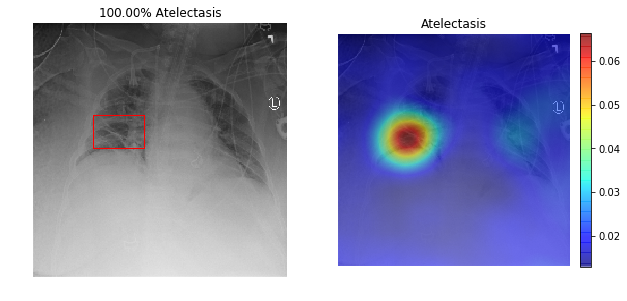

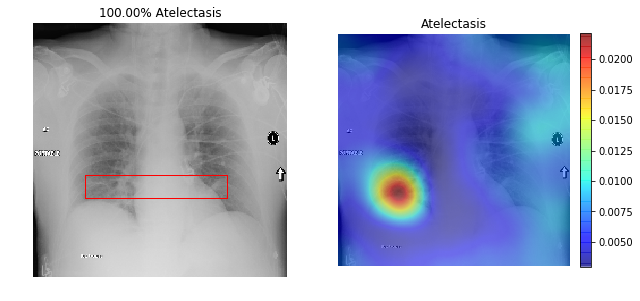

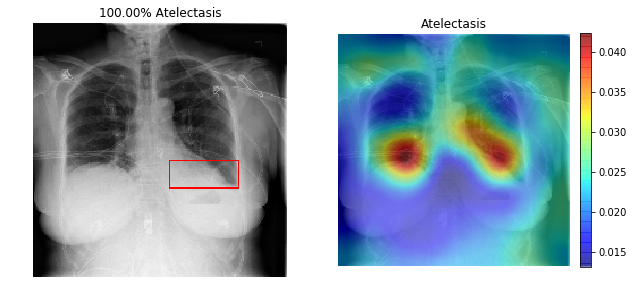

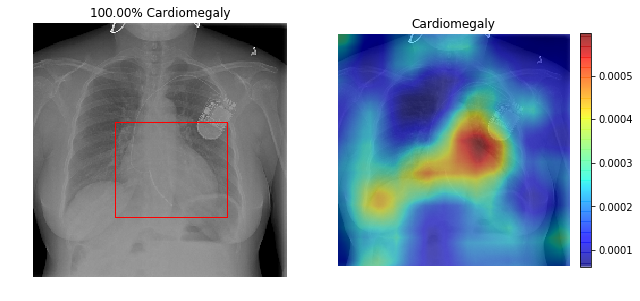

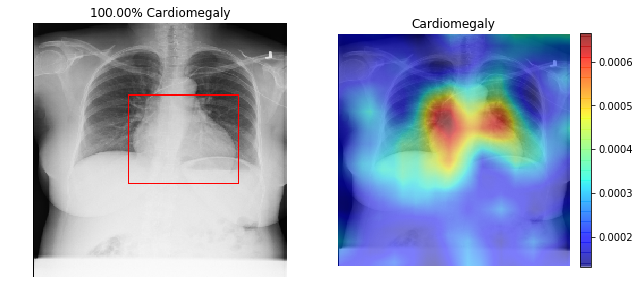

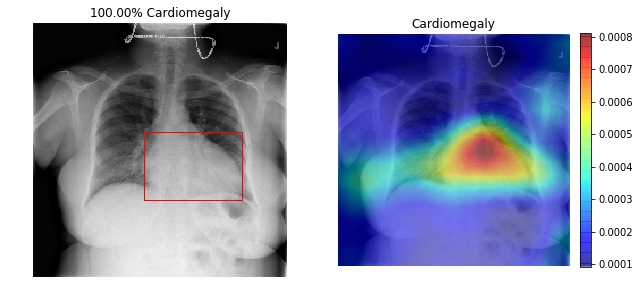

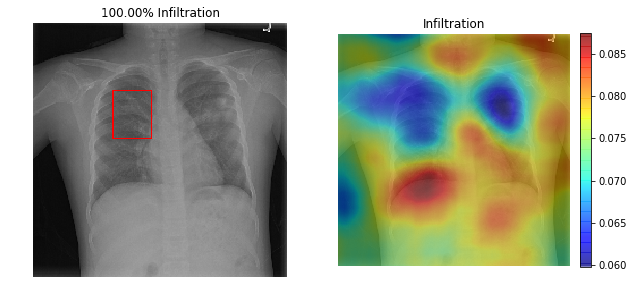

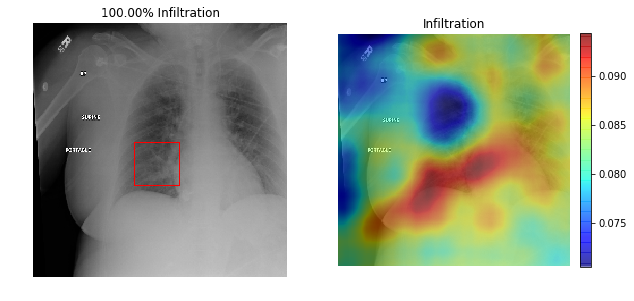

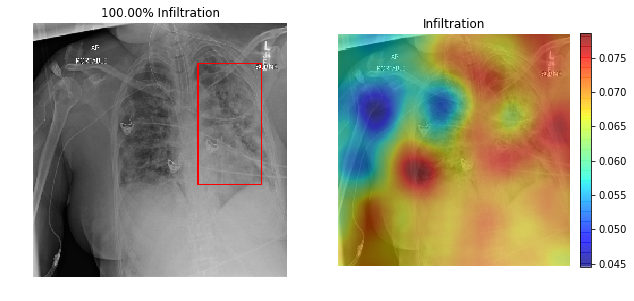

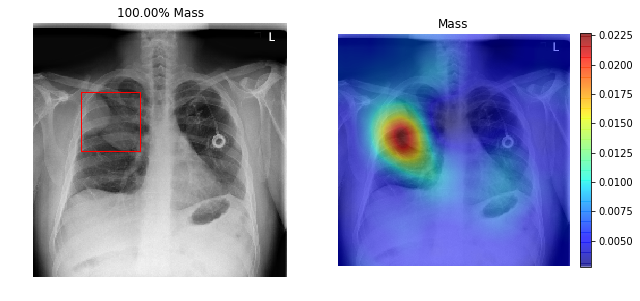

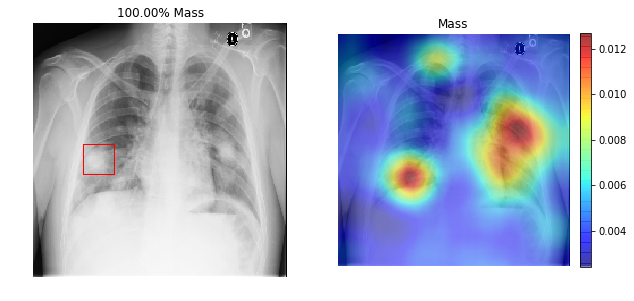

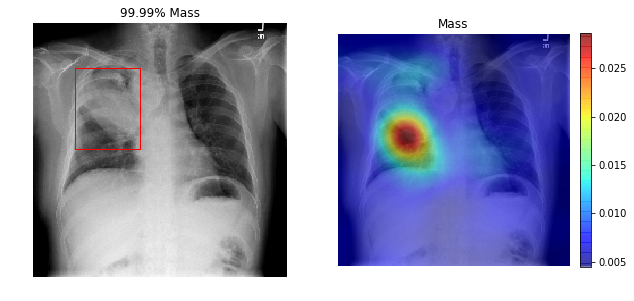

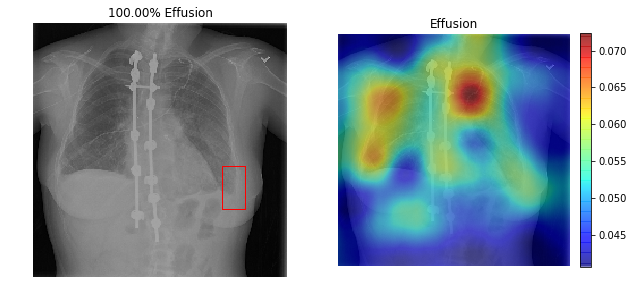

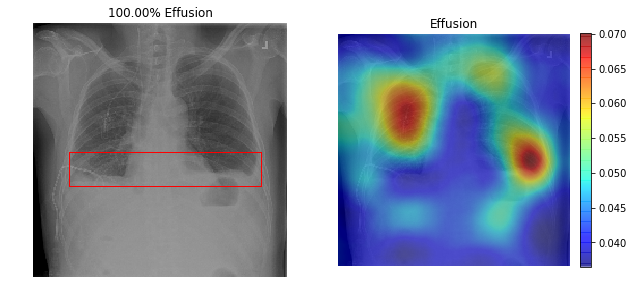

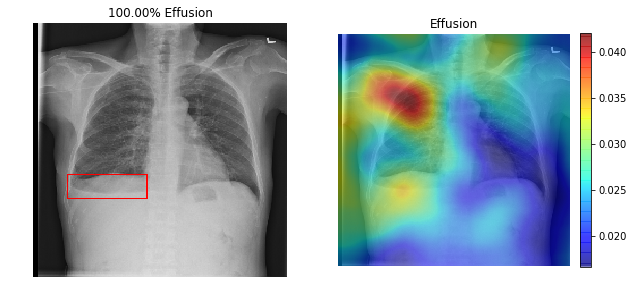

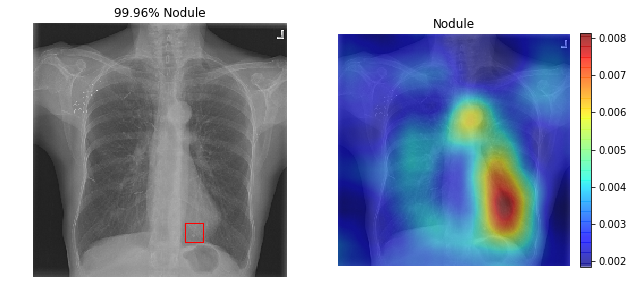

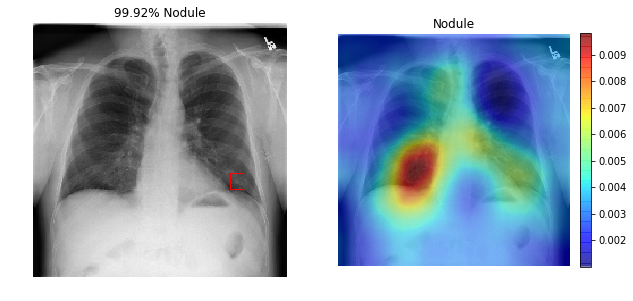

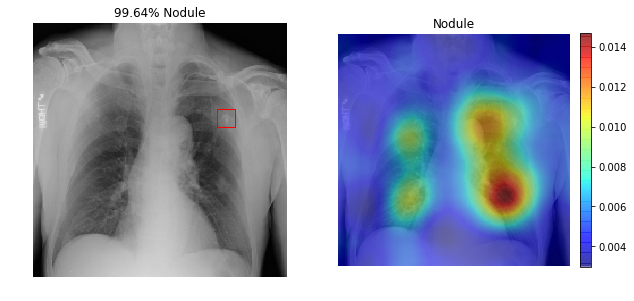

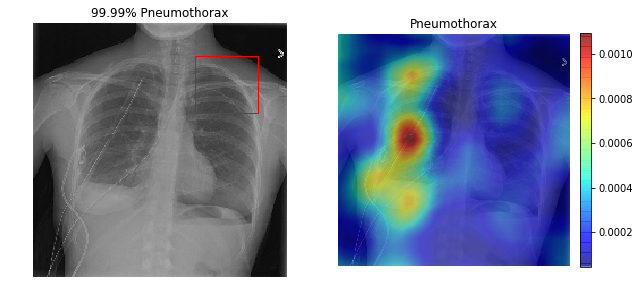

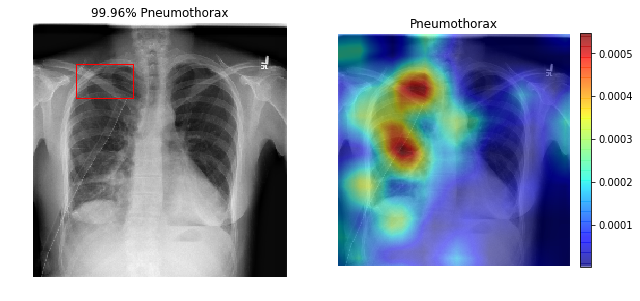

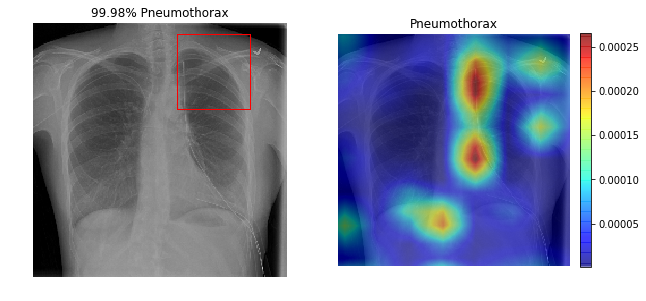

In [7]:
with torch.set_grad_enabled(False):
    for images in data.values():
        for image in images[:3]:
            img, tensor = load_image_tensor('../data/processed_images/' + image['image'], unsqueeze=True)
            rise(tensor, img, image['image'], 1)